
# HW3: Simple Linear Regression with Sacramento Real Estate Data

---

In this HW you will apply your EDA skills and practice constructing simple linear regressions using a dataset on Sacramento real estate sales.  The dataset contains information on qualities of the property, location of the property, and time of sale.

**You are expected to create and enter MULTIPLE relevant cells in each part.**   
**Explain with markdown cells any reason that support your finding or action.**   
**Points may be deducted if no appropriate interpretation is provided.**

*you may download the dataset used in this HW from here: 1RW87ZmENMHrS8K9iPPwmnHfYxmb-w0Qr*


### 1. Read in the Sacramento housing data set.

In [0]:
#1 Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#2. Get the file
#make sure you upload all your data files to your Google drive and change share->Advanced->change->anyone with the link can view
downloaded = drive.CreateFile({'id':'17HbHBVlcAsqs0Yi7IGnZAt5u2-sl9B7L'}) # replace the id with id of file you want to access
downloaded.GetContentFile('drug-use-by-age.csv') 
downloaded = drive.CreateFile({'id':'1RW87ZmENMHrS8K9iPPwmnHfYxmb-w0Qr'}) # replace the id with id of file you want to access
downloaded.GetContentFile('sacramento_real_estate_transactions.csv')


In [0]:
sac_csv = 'sacramento_real_estate_transactions.csv'

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn.metrics import mean_squared_error 

% matplotlib inline

### 2. Conduct exploratory data analysis (EDA) on this data set. 

**Show how you exolore this dataset     
Explain any steps you take to clean/transform your data.   
Do not transform your data without any reasoning.**

## Exploratory Data Analysis

Read csv data using pandas 

In [0]:
# A:
housing = pd.read_csv('sacramento_real_estate_transactions.csv')
housing.head(5)

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


#### Check the datatype


It is necessary to look over the shape of the dataset before you start analyzing on the data.

#### The Housing data consists of 985 rows and 12 columns.

In [0]:
## Shape of the dataset
housing.shape

(985, 12)

#### Look for null values in the dataset

In [0]:
housing.isnull().sum()

street       0
city         0
zip          0
state        0
beds         0
baths        0
sq__ft       0
type         0
sale_date    0
price        0
latitude     0
longitude    0
dtype: int64

#### There are no null values in the dataset, which is a good sign for our analysis


 Check the datatypes in the dataframe.

In [0]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
street       985 non-null object
city         985 non-null object
zip          985 non-null int64
state        985 non-null object
beds         985 non-null int64
baths        985 non-null int64
sq__ft       985 non-null int64
type         985 non-null object
sale_date    985 non-null object
price        985 non-null int64
latitude     985 non-null float64
longitude    985 non-null float64
dtypes: float64(2), int64(5), object(5)
memory usage: 92.4+ KB


####  Here, there are 2 floats, 5 integers and 5 objects were present

Street, City, State,Type and Sale_date were the string objects

In [0]:
## Date is a column in the dataframe
## Let's convert it into index
#Set date as index
housing.set_index('sale_date', inplace=True)



Here, the  sale_date can be converted into index of our dataframe. The sale_date helps us in knowing the basic information on the price with respect to date. Hence we converted it into index

In [0]:

## Lets see how many states are in 

housing.state.value_counts()

CA    984
AC      1
Name: state, dtype: int64

There are 984 records with in california state and one Record is from "AC" which is unknown let's investigate on it.

In [0]:
housing.loc[housing['state'] == 'AC']

,street,city,zip,state,beds,baths,sq__ft,type,price,latitude,longitude
sale_date,,,,,,,,,,,
Fri May 16 00:00:00 EDT 2008,1900 DANBROOK DR,SACRAMENTO,95835,AC,1,1,-984,Condo,-210944,-121.503471,38.668433


Here, if we carefully look over city we can confirm that state is 'AC' but city was Sacremento. we can make a conclusion that state name got wrong. So,we can modify it into 'CA' .    

And, there are some other insights we can get from the dataset. The sq__ft can't be negative. moreover, price which should not be negative value. 

In [0]:
# Replace state 'AC' into 'CA'.
housing['state'] = ['CA' if x == 'AC' else x for x in housing['state']] 


In [0]:
housing.state.value_counts() # We had modified 'AC' to 'CA'. Now it become 985 records

CA    985
Name: state, dtype: int64

Let's get into another column. Lets see what types of houses are available in the dataset

In [0]:
housing.type.value_counts() ## There is one 'Unknown', 'type' house

Residential     917
Condo            54
Multi-Family     13
Unkown            1
Name: type, dtype: int64

If we observe the "type" "Unkown" in the dataset. There are two ways to deal with this. Either remove the whole record from the dataset or replace the "type" with some other known type.

In [0]:
housing.loc[housing['type'] == 'Unkown']

,street,city,zip,state,beds,baths,sq__ft,type,price,latitude,longitude
sale_date,,,,,,,,,,,
Fri May 16 00:00:00 EDT 2008,6007 MARYBELLE LN,SHINGLE SPRINGS,95682,CA,0,0,0,Unkown,275000,38.64347,-120.888183


Here, we have very less number of records. Removing records is not a good idea. So we can replace the value.

#### Let's see what types of houses are there in the zip '95682' .

In [0]:
housing.loc[housing['zip'] == 95682]

,street,city,zip,state,beds,baths,sq__ft,type,price,latitude,longitude
sale_date,,,,,,,,,,,
Tue May 20 00:00:00 EDT 2008,2778 KAWEAH CT,CAMERON PARK,95682,CA,3,1,0,Residential,201000,38.694052,-120.995589
Tue May 20 00:00:00 EDT 2008,3361 BOW MAR CT,CAMERON PARK,95682,CA,2,2,0,Residential,210000,38.694370,-120.996602
Tue May 20 00:00:00 EDT 2008,3429 FERNBROOK CT,CAMERON PARK,95682,CA,3,2,2016,Residential,399000,38.664225,-121.007173
Mon May 19 00:00:00 EDT 2008,2809 LOON CT,CAMERON PARK,95682,CA,4,2,0,Residential,423000,38.687072,-121.004729
Fri May 16 00:00:00 EDT 2008,3330 VILLAGE CT,CAMERON PARK,95682,CA,2,2,0,Residential,195000,38.690504,-120.996245
Fri May 16 00:00:00 EDT 2008,2733 YUMA CT,CAMERON PARK,95682,CA,2,2,0,Residential,215000,38.691215,-120.994949
Fri May 16 00:00:00 EDT 2008,6007 MARYBELLE LN,SHINGLE SPRINGS,95682,CA,0,0,0,Unkown,275000,38.643470,-120.888183
Fri May 16 00:00:00 EDT 2008,2818 KNOLLWOOD DR,CAMERON PARK,95682,CA,3,2,0,Residential,425000,38.669805,-120.999007
Thu May 15 00:00:00 EDT 2008,3035 ESTEPA DR Unit 5C,CAMERON PARK,95682,CA,0,0,0,Condo,119000,38.681393,-120.996713


Here, majority were residential.So, we can replace 'Unkown' type into 'Residnetial' type.




In [0]:
housing['type'] = ['Residential' if x == 'Unkown' else x for x in housing['type']]


In [0]:
housing.type.value_counts() ## Now we have replaced the 'Unkown' value from the dataframe into 'Residential'

Residential     918
Condo            54
Multi-Family     13
Name: type, dtype: int64

In [0]:
# We can see the summary statistics of the data.
housing.describe().T

,count,mean,std,min,25%,50%,75%,max
zip,985.0,95750.697462,85.176072,95603.000000,95660.000000,95762.000000,95828.000000,95864.000000
beds,985.0,2.911675,1.307932,0.000000,2.000000,3.000000,4.000000,8.000000
baths,985.0,1.776650,0.895371,0.000000,1.000000,2.000000,2.000000,5.000000
sq__ft,985.0,1312.918782,856.123224,-984.000000,950.000000,1304.000000,1718.000000,5822.000000
price,985.0,233715.951269,139088.818896,-210944.000000,145000.000000,213750.000000,300000.000000,884790.000000
latitude,985.0,38.445121,5.103637,-121.503471,38.482704,38.625932,38.695589,39.020808
longitude,985.0,-121.193371,5.100670,-121.551704,-121.446119,-121.375799,-121.294893,38.668433


From the above describe table we got lot of insights on the data.

1.  The column price,sq__ft are having negative value as minimum. There won't be the posibility of negative value for these.
2. There are 0 beds, 0 bathrooms  and we have the price for that data.  
     Now, we had two choice in dealing with this data.   
     Method1: Remove the records contaning the negative and zero values.    
     Method2:  impute  with absolute mean values.    
     
3. We can choose imputing with mean for beds and baths columns that are containig zero value.    
4. Replace the negative values with absolute value.
    


In [0]:
## Replace the negative values with absolute values in price and sq__ft
housing['price'] = housing['price'].abs()

housing['sq__ft'] = housing['sq__ft'].abs()

In [0]:
## Replace zero with mean values for 'bath','beds' and 'sq__ft'.

dat = housing['baths'].mean()
dat = round(dat)
dat

dat1 = housing['beds'].mean()
dat1 = round(dat1)


dat2 = housing['sq__ft'].mean()

dat2 = round(dat)


housing['sq__ft'] = [dat2 if x == 0 else x for x in housing['sq__ft']]

housing['baths'] = [dat if x == 0 else x for x in housing['baths']]

housing['beds'] = [dat1 if x == 0 else x for x in housing['beds']]



## Outlier Detection Analysis

Linear Regression is susceptible for Outliers

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


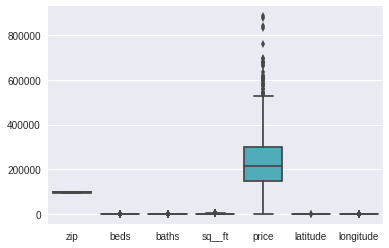

In [0]:
import seaborn as sns
sns.boxplot(x=housing)

(array([ 96., 269., 304., 160.,  76.,  43.,  22.,  10.,   1.,   4.]),
 array([  1551. ,  89874.9, 178198.8, 266522.7, 354846.6, 443170.5,
        531494.4, 619818.3, 708142.2, 796466.1, 884790. ]),
 <a list of 10 Patch objects>)

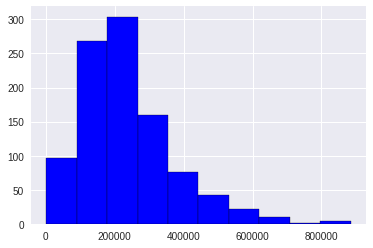

In [0]:
plt.hist(housing['price'], color = 'blue', edgecolor = 'black',)

We can see that the dependent variable is not possessing normal distribution. As there are outliers in the data, causing the disitribution to get skewed. Let's remove the outliers from the data.

#### There are two ways to remove the outliers.
Ways to detect outliers in the dataset.    
1.   Using of Z-Score, eliminate the data which falls beyond 3 standard deviations. This is  one way, we can try to eliminate the outliers.

2. IQR range, It tells how the spread of middle values are. It tells when a value is too far from the middle.
 ( An Outlier is a point which falls more than 1.5 times the IQR range and above 3rd quartile range and below 1st quartile range).

3.  With a scatter plot you can also try to find those values.

Lets go with Standard deviation in normal distribution concept.

In [0]:
housing = housing[np.abs(housing.price - housing.price.mean()) <= (3*housing.price.std())]

# house = housing_new1[~(np.abs(housing_new1.price-housing_new1.price.mean()) > (3*housing_new1.price.std()))]


If you observe the mean house price after removing the outliers, there is a change in the value.

In [0]:
housing.price.max() # Maximum house price.

636000

In [0]:
## Outlier datapoints in the price column

In [0]:
import numpy as np
import pandas as pd
outliers=[]

#data1 = housing.price
def detect_outlier(data_1):
    
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers


In [0]:
outlier_datapoints = detect_outlier(housing.price)
print(outlier_datapoints)
len(outlier_datapoints)

[606238, 613401, 614000, 636000, 610000, 622500]


6

## Linear Regression Assumptions.
It is important to understand the complete behavior of the data,before applying linear regression technique on the data.

1.    The dependent Variable and error must posses a normal distribution.

2.  There should exist linear relation between independent and dependent variable.

3.  There should be no correlation between independent variables.This may lead to multicolinearity.

4.  Error terms must possess constant variance.absence of this leads to heteroskedacity.

5. The error terms must be uncorrelated. Presence of that leads to auto correlation

### Most important every feature should be in numeric type in linear regression model

#### Here, we have "State", "City", "Street ", "Type" are categorical data. But Zip code was in numeric type. It should be converted into categorical data.

Zip code was not a measurable quantity, hence we can convert into categorical type.

In [0]:
# Convert zip into string object
housing['zip'] = housing['zip'].astype(str)

There can't be categorical type data, while building an linear regression model. Let's convert categorical one into numeric by applying transformations.



That is, convert categorical into dummy variables.

#### Create dummy variables using `get_dummies` from Pandas.

In [0]:
street_dummies = pd.get_dummies(housing.street, prefix='street')

city_dummies = pd.get_dummies(housing.city,prefix = 'city')

zip_dummies = pd.get_dummies(housing.zip,prefix = 'zip')

state_dummies = pd.get_dummies(housing.state,prefix = 'state')

type_dummies = pd.get_dummies(housing.type,prefix = 'type')

#### Inspect the `DataFrame` of `dummies`.

In [0]:
# Print five random rows.
type_dummies.sample(n=5, random_state=1)

,type_Condo,type_Multi-Family,type_Residential
sale_date,,,
Mon May 19 00:00:00 EDT 2008,0,0,1
Mon May 19 00:00:00 EDT 2008,0,0,1
Tue May 20 00:00:00 EDT 2008,0,0,1
Fri May 16 00:00:00 EDT 2008,0,0,1
Tue May 20 00:00:00 EDT 2008,0,0,1


In [0]:
#housing.columns

#### Drop the first column.



In general, if you have a categorical feature with k possible values, you create k-1 dummy variables.
These k-1 variables capture maximum amount of information.


In [0]:
street_dummies.drop(street_dummies.columns[0], axis=1, inplace=True)

In [0]:
city_dummies.drop(city_dummies.columns[0],axis = 1,inplace = True)

In [0]:
type_dummies.drop(type_dummies.columns[0],axis = 1,inplace = True)

In [0]:
state_dummies.drop(state_dummies.columns[0],axis = 1,inplace = True)

In [0]:
zip_dummies.drop(zip_dummies.columns[0],axis = 1,inplace = True)

### 3. Our goal will be to predict the price. List variables that you think qualify as predictors of price in a SLR model. 

**For EACH of these variables you believe to be valid potential predictors in an SLR model, generate a sns.lmplot showing the relationship between the the feature variable and target variable.**

We have following variables in our data set.   

Street,  City,  zip,   state,   beds,  sq__ft,   baths,  type,  price,   latitude,   longitude

These are the  important varibles that are present in our dataset.

Zip should not be numeric type. We need to convert into categorical data.

A scatter plot can be good with numeric type data. Hence, here we have beds, sq__ft, baths,  type,  price,  latitude and longitude are numeric type.

Note, as per domain knowledge is concern, we have sufficent data on geographic loction, which can hlep us in predicting the price but latitude and longitude seems won't contribute much to the model. 

If we observe the relation between them as well. There is no linearity between them.






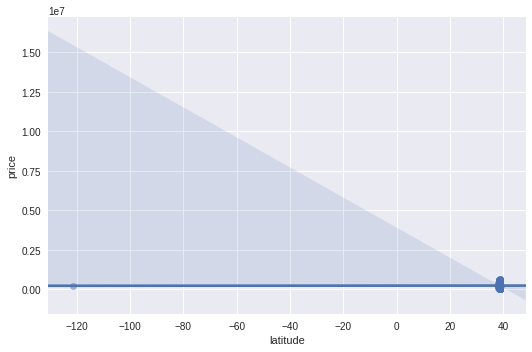

In [0]:
sns.lmplot(x='latitude', y='price', data=housing, aspect=1.5, scatter_kws={'alpha':0.5})

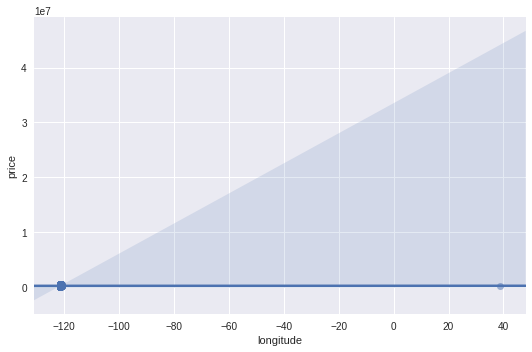

In [0]:
sns.lmplot(x='longitude', y='price', data=housing, aspect=1.5, scatter_kws={'alpha':0.5})

It is clear that latitude and longitue are not good predictor variables to our model.Because one of our main assumption is that there should be an linear relationship between dependent and independent variable.



We can remove latitude and longitude variables from the dataset.



In [0]:
#zip_dummies.drop(zip_dummies.columns[0],axis = 1,inplace = True)

housing.drop('latitude',axis = 1,inplace = True)

In [0]:
housing.drop('longitude',axis = 1, inplace = True)

In [0]:
housing.head(5)

,street,city,zip,state,beds,baths,sq__ft,type,price
sale_date,,,,,,,,,
Wed May 21 00:00:00 EDT 2008,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,59222
Wed May 21 00:00:00 EDT 2008,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,68212
Wed May 21 00:00:00 EDT 2008,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,68880
Wed May 21 00:00:00 EDT 2008,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,69307
Wed May 21 00:00:00 EDT 2008,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,81900


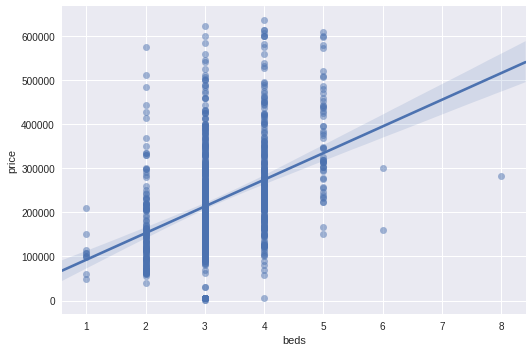

In [0]:
## Scatter Plot for beds vs price
import seaborn as sns
sns.lmplot(x='beds', y='price', data=housing, aspect=1.5, scatter_kws={'alpha':0.5})

There is an linear relationship between price and beds.Hence, beds could be a good feature for the model.




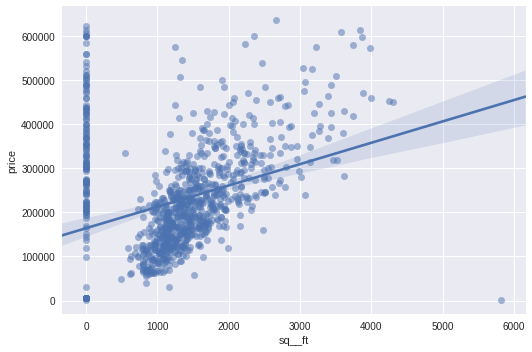

In [0]:
# A

# Seaborn scatterplot with regression line (a big plus that helps us to see the trend)
# Sq__ft vs price
sns.lmplot(x='sq__ft', y='price', data=housing, aspect=1.5, scatter_kws={'alpha':0.5})

Here,Sq__ft vs price forms linear relation. This can also be the good feature to the model.


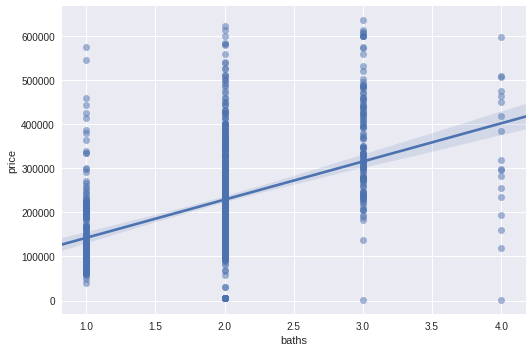

In [0]:
sns.lmplot(x='baths', y='price', data=housing, aspect=1.5, scatter_kws={'alpha':0.5})

Baths vs Price forms linear relationship. It can also be the good predictor to our model.

## Correlation map:


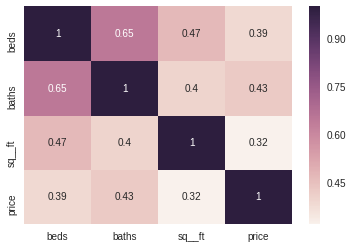

In [0]:
sns.heatmap(housing.corr().abs(),annot = True)
#sns.heatmap(housing, annot=True)#, annot_kws={"size": 7})


In [0]:
housing.corr().abs().price.sort_values(ascending= False)

price     1.000000
baths     0.428919
beds      0.389466
sq__ft    0.321601
Name: price, dtype: float64

There is a high correlation between price and baths and least correlation between Sq__ft and price.




### 4. Which SINGLE variable would be the best predictor of Y in a SLR model? Why?

In [0]:
feature_cols = ['sq__ft']
X = housing_new[feature_cols]
y = housing_new.price

from sklearn.linear_model import LinearRegression
# Instantiate an object out of linear regression class.
lr = LinearRegression()

lr.fit(X, y) ## With sq__ft as single variable
lr.score(X,y) ## R2 score value

In [0]:
X

In [0]:
feature_cols1 = ['baths']
X_1 = housing[feature_cols1]
y = housing.price

lr.fit(X_1,y) # with baths as single variable
lr.score(X_1,y) #R square score value

In [0]:
feature_cols2 = ['beds']
X_2 = housing[feature_cols2]
y = housing.price

lr.fit(X_2,y) # with beds as single variable
lr.score(X_2,y) # R-Square score



0.15168373384969058

If we observe all considered numeric features the variable with "baths" has high r square score compared to other variables. Hence, we can make conclusion that single variable "baths" could be the good input in predicting price.




### 5. Build a function that will take in two lists `Y` and `X` and returns the intercept and slope coefficients that minimize SSE. 

`Y` is the target variable and `X` is the predictor variable.

- **Test your function on price and the variable you determined was the best predictor in Problem 4.**
- **Report the slope and intercept.**
- **Report its score.**

In [0]:
# A:

feature_cols1 = ['baths']
X = housing[feature_cols1]
Y = housing.price

lr.fit(X_1,y) # with baths as single variable
lr.score(X_1,y) #R square score value


def lrmodel(X,Y):
  
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X,Y)
  
  
print("Intercept:",lr.intercept_)
print("Slope: ",lr.coef_)
print("R-Square score:", lr.score(X,Y))

Intercept: 55754.88729878215
Slope:  [86656.25327043]
R-Square score: 0.18397121090040536


### 6. Interpret the intercept. Interpret the slope.

Ans: 
 For understanding see Q.8 graph

Slope is a consistent change in relationship between independent and dependent variable in a linear model.

 Intercept say's that Even with a zero value in feature baths, we can predict  price for the house would be 55754.887

 Slope say's that for every unit change in baths the change in price will be 86656.25


### 7. Give a real life example of how this model could help people in prediction. Also give an example that the model can be used for inference purpose. You should consider non-technical people as users in your example.

**Be sure to make it clear which example is associated with prediction and which is associated with inference.**

Ans:   

Let's say a person wants to purchase a new house. In general, Common people have the good idea on how much area, he/she wants in their house and number of rooms, and baths so on. Having all the features are good thing but price varies from region to region. So, Ideally this model helps in precting the house price in Sacremento region( As the data is taken from sacremento real estate) With their basic inputs such as sq__ft baths,beds and street etc.

Here, I built using single feature baths but if we implement on Multiple features using multi linear regression technique the model can give good results in predicting the price.

### 8: Using the model you came up with in Problem 5, calculate the residuals (MSE) and plot the targets vs. the prediction with the linear regression line.

Mean_Squared_Error: 12906320957.593456


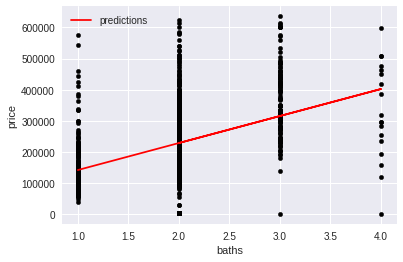

In [0]:
# A:



predictions  =  lr.predict(X)
score        =  lr.score(X,Y)
housing['predictions'] = predictions

ax1 = housing.plot(kind='scatter',x='baths', y='price', color='black')
housing.plot(kind='line',x='baths', y='predictions', color='red',ax=ax1)


#from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(housing.price,housing.predictions)
print('Mean_Squared_Error:',MSE)

In [0]:
import class--> instantiate the class --> fit model --> scre --> predictt

Here, the model is underfitting.